**    ARIMA MODEL  **
                                                            
I was recently tasked with creating a monthly forecast for the next year for the sales of a product. In my research to learn about time series analysis and forecasting, I came across three sites that helped me to understand time series modeling, as well as how to create a model.

From my research, I realized I needed to create a seasonal ARIMA model to forecast the sales. I was able to piece together how to do this from the sites, but none of them gave a full example of how to run a **Seasonal ARIMA model in Python**. So this is a quick tutorial showing that process.

** I hope you find this kernel helpful and some UPVOTES would be very much appreciated
**


Import the packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') #to ignore if any warnings takes place during the run time.
#import statsmodels.api as sm


In [ ]:
#read the data
df=pd.read_csv('../input/train.csv')
df.head()

In [ ]:
#check for missing values in train data
 df.isnull().sum()
 #No missing valuues



Here for better understanding of the data, We can eloborate as month and weekday wise.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:

# per 1 store, 1 item
train_df = df[df['store']==1]
train_df = train_df[df['item']==1]

# train_df = train_df.set_index('date')
train_df['year'] = df['date'].dt.year
train_df['month'] = df['date'].dt.month
train_df['day'] = df['date'].dt.dayofyear
train_df['weekday'] = df['date'].dt.weekday

train_df.head()

Below plots are for checking the seasonality, trends and outliers.

In [ ]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

In [ ]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

In [ ]:
sns.boxplot(x="weekday", y="sales", data=train_df)

In [ ]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df.head()

**Time series decomposition**

Think of the time series ytyt as consisting of three components: a seasonal component, a trend-cycle component (containing both trend and cycle), and a remainder component (containing anything else in the time series).
1. Additive model
1. Multiplicative model

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series.

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate.

**play this quiz you will come familiar with additive or multiplicative** https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/ 


**Should I use an additive model or a multiplicative model?**

Choose the multiplicative model when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. In other words, the magnitude of the seasonal pattern increases as the data values increase, and decreases as the data values decrease.
Choose the additive model when the magnitude of the seasonal pattern in the data does not depend on the magnitude of the data. In other words, the magnitude of the seasonal pattern does not change as the series goes up or down.
If the pattern in the data is not very obvious, and you have trouble choosing between the additive and multiplicative procedures, you can try both and choose the one with smaller accuracy measures.



In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


 The yearly pattern is very obvious. and also we can see a upwards trend. Which means this data is not stationary.



First Need to know about 2 things. 

1)	**Trend:** change in the graph upward or downward with respect to time period. 

2)	**Seasonality:** for instance:  sudden increase in the cost of product like pizza, ice creams etc,.

In order to apply ARIMA the data need to be stationary, In the sense the data should not be changed with respect to time.

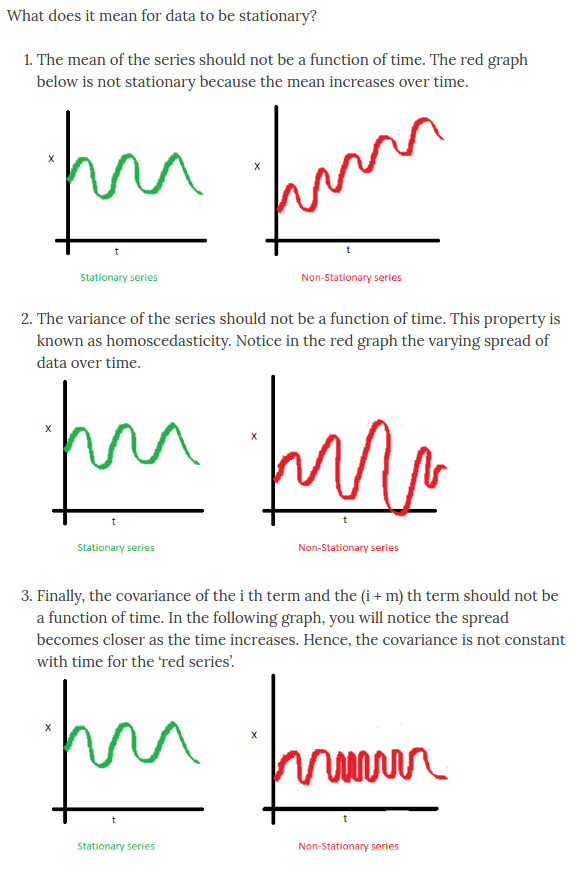






If a time series is stationary and has a particular behaviour over a given time interval, then it is safe to assume that it will have same behaviour at some later point in time. Most statistical modelling methods assume or require the time series to be stationary.

**What is variance?  **

Variance is a measurement of the spread between numbers in a data set. The variance measures how far each number in the set is from the mean. The square root of variance is the standard deviation.



**How to check Whether data is Stationary or not ?**


There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the **Dickey-Fuller test**. I won’t go into the specifics of this test, but if the **‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary**. Below is code that will help you visualize the time series and test for stationarity.


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
   
    
    

In [ ]:
test_stationarity(train_df['sales'])

**How to find whether our data is stationary or not ?**

the smaller p-value, the more likely it's stationary. Here our p-value is 0.036. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.
To get a stationary data, there's many techiniques. We can use log, differencing etc...

**NOTE**

If the **p-value** is less than 5%(significance level) or If the **Test Static** value is greater than than the **Critical value** than our data is stationary

In [ ]:
#this is for reducing trend and seasonality
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

**ACF (Auto Corelation Function) and (Partial Auto Corelation Function)**

 **What is ACF ?**
 
 For Instance today stock price we predicted based on yesterday stock price the ACF will tell how much strongly they are corelated, If todays value is depended on day before yesterday than ACF will tell how strong they are and how many days required to predict the todays value.
 
 **What is PACF?**
 
 If we want to calculate the corelation between today and yesterday we have to take the corelation of day before yesterday because todays value depends upon the yesterday time spot. So this is the reason we use PACF.

  ** PACF- AR model**
   
   **ACF- MA model**
   
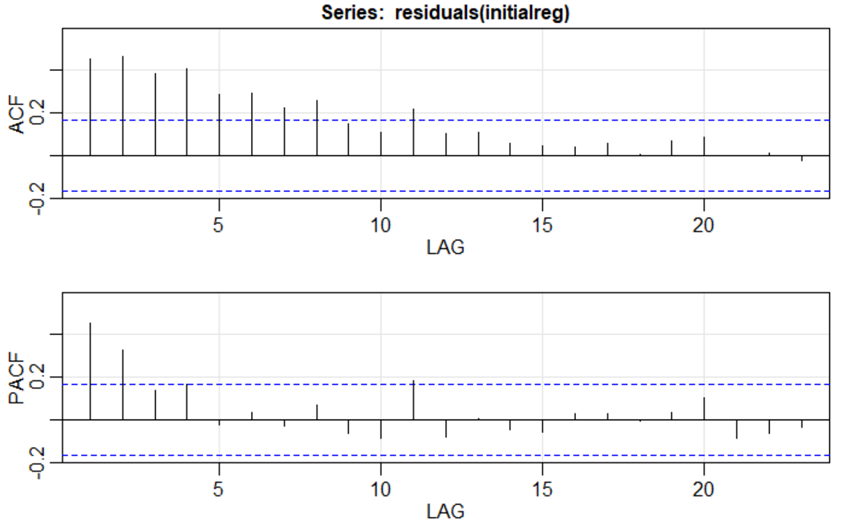

by the above images we can observe that, the lines which crosses the blue dotted lines in PACF and ACF those lines are considered to be that many days are required to predict the todays value. **For example in above PACF plot that has only three lines which crossed the blue dotted lines so last three days values are required to predict the todays value**, similarly ACF plot also but for model we should not consider ACF-MA model because many lines crossed the blue threshold line, so it will create the model complex. So we should select only PACF-AR model to predict

   ***if you want to know more about PACF and ACF go through this link***     https://www.youtube.com/watch?v=5Q5p6eVM7zM

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)      #lags=40

By seeing the above plots, there are lots of significant plots so as previously i explained if more lines crossed the blue line, than the model will get complex so go for the first difference. 

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont


**How to determin p, d, q**

It's easy to determin I. In our case, we see the first order differencing make the **ts stationary. I = 1.**

In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use **AR = 6 (6 lines are crossed the blue lines so 6past days are required to predict)**

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [ ]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

**Analyze the result**

To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.



In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

When the plots of ACF and PACF are similar or any sesaonality is present between them than we need to apply **SARIMA** model, which it is extended model of **ARIMA**

**What is SARIMA and what is the use of it ?**

ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting, but it does not support time series with a seasonal component. The ARIMA model is extended (SARIMA) to support the seasonal component of the series. SARIMA (Seasonal Autoregressive Integrated Moving Average), method for time series forecasting is used on univariate data containing trends and seasonality. SARIMA is composed of trend and seasonal elements of the series.

Some of the parameters that are same as ARIMA model are:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order
There are four seasonal elements that are not part of ARIMA are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
Thus SARIMA model can be specified as:
SARIMA (p, d, q) (P,D,Q) m

If m is 12, it specifies monthly data suggests a yearly seasonal cycle.
SARIMA time series models can also be combined with spatial and event based models to yield ensemble models that solves multi-dimensional ML problems. Such a ML model can be designed to predict cell load in cellular networks at different times of the day round the year as illustrated below in the sample figure
Autocorrelation, trend, and seasonality (weekday , weekend effects) from time series analysis can be used to interpret temporal influence.
Regional and cell wise load distribution can be used to predict sparse and over loaded cells in varying intervals of time.
Events (holidays, special mass gatherings and others) can be predicted using decision trees.

**Reference :**

https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a



In [ ]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

******

In [ ]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

**Make prediction and evaluation**

Take the last 30 days in training set as validation data



In [ ]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

**Evaluations of the model**

In [ ]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [ ]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

**Conclusion**

The study concludes with some case studies why specific machine learning methods perform so poorly in practice, given their impressive performance in other areas of artificial intelligence.
The challenge leaves it open to evaluate reasons of poor performance for ARIMA/SARIMA and LSTM models, and devise mechanisms to improve model’s poor performance and accuracy. Some of the areas of application of the models and their performance is listed below:

ARIMA yields better results in forecasting short term, whereas LSTM yields better results for long term modeling.
Traditional time series forecasting methods (ARIMA) focus on univariate data with linear relationships and fixed and manually-diagnosed temporal dependence.
Machine learning problems with substantial dataset, its found that the average reduction in error rates obtained by LSTM is between 84–87 percent when compared to ARIMA indicating the superiority of LSTM to ARIMA.

The number of training times, known as “epoch” in deep learning, has no effect on the performance of the trained forecast model and it exhibits a truly random behavior.

LSTMs when compared to simpler NNs like RNN and MLP appear to be more suited at fitting or overfitting the training dataset rather than forecasting it.

Neural networks (LSTMs and other deep learning methods) with huge datasets offer ways to divide it into several smaller batches and train the network in multiple stages. 
The batch size/each chunk size refers to the total number of training data used. The term iteration is used to represent number of batches needed to complete training a model using the entire dataset.

LSTM is undoubtedly more complicated and difficult to train and in most cases do not exceed the performance of a simple ARIMA model.



